# Production-Ready Inference
The production-ready inference Jupyter Notebook is meant to allow a user-friendly inference that can be run in local, without the need to struggle for understanding deeply what is going on under the hood of our model and trying to find a way out from our hierarchy!

Before running this notebook, make sure that you have all of these things in place:
1. You have inserted the images for which you want your annotations to be predicted inside the **INFERENCE_DIR** folder.
2. You have added a file named **annotations.csv** to the **ANNOTATIONS&PREDICTIONS** folder, if you want your ground-truth annotations to be compared to the predictions made by our model.

# SEE WHETHER TO ADD HERE THE CHECKPOINTS ALREADY!

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import os
import logging
import glob
import pandas as pd

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [31]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [32]:
model = "model_folder"
config = "bestmodel"

current_working_directory = "/".join(os.getcwd().split("\\")[:-1])
output_directory = f'{current_working_directory}/inference_PROD/{model}/FINE_TUNED_MODEL/{config}'

print(f"The current working directory is: {current_working_directory} and the fine-tuned model is contained in {output_directory}")

The current working directory is: c:/Users/rebec/Documents/GitHub/ObjectRecognition/LogoDetection_DSBAProject and the fine-tuned model is contained in c:/Users/rebec/Documents/GitHub/ObjectRecognition/LogoDetection_DSBAProject/inference_PROD/model_folder/FINE_TUNED_MODEL/bestmodel


# Changes to the pipeline files


# Run the inference over your images

In [33]:
import pathlib

filenames = list(pathlib.Path(os.path.join(output_directory,"checkpoint")).glob('*.index'))
filenames.sort()
print(filenames)

#recover our saved model
pipeline_file = f"{current_working_directory}/inference_PROD/{model}/deploy/config_6/pipeline_file.config"
print(pipeline_file)
pipeline_config = pipeline_file

#generally you want to put the last ckpt from training in here
model_dir = str(filenames).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
#print(model_config)
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)

print(detection_model)
print(filenames)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    
    
    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[WindowsPath('c:/Users/rebec/Documents/GitHub/ObjectRecognition/LogoDetection_DSBAProject/inference_PROD/model_folder/FINE_TUNED_MODEL/bestmodel/checkpoint/ckpt-0.index')]
c:/Users/rebec/Documents/GitHub/ObjectRecognition/LogoDetection_DSBAProject/inference_PROD/model_folder/deploy/config_6/pipeline_file.config
[WindowsPath('c:/Users/rebec/Documents/GitHub/ObjectRecognition/LogoDetection_DSBAProject/inference_PROD/model_folder/FINE_TUNED_MODEL/bestmodel/checkpoint/ckpt-0.index')]


In [34]:
#map labels for inference decoding
label_map_path = f"{current_working_directory}/inference_PROD/{model}/label_map/logos_label_map.pbtxt"
#label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

print(label_map_dict)

{'Adidas': 1, 'AppleInc': 2, 'MercedesBenz': 3, 'NFL': 4, 'Nike': 5, 'Puma': 6, 'Starbucks': 7, 'TheNorthFace': 8, 'UnderArmour': 9}


In [35]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 

import random

TEST_IMAGE_PATHS = glob.glob(f'{current_working_directory}/inference_PROD/INFERENCE_DIR/*.jpg')

In [36]:
import matplotlib.patches as patches
import time

def print_true_predicted(image):

    if "COMPARE" not in os.listdir(os.getcwd()):
        os.mkdir(os.path.join(os.getcwd(), "COMPARE"))

    image_path = image
    image_np = load_image_into_numpy_array(image_path)

    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    threshold = 0.2
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True, # Needs to be true cause otherwise boxes go out of range
                  max_boxes_to_draw=3, # Minimized to 10 because otherwise we might have troubles 
                  min_score_thresh=threshold, # Minimized the score, as for now it seems to be too confident over Adidas
                  agnostic_mode=False)
    
    df_general_annot = pd.read_csv(f"{current_working_directory}/inference/data_iou/_annotations.csv")
    simple_filename = image.split("\\")[-1]
    df_true_annot = df_general_annot[df_general_annot["filename"]==simple_filename]
    
    plt.figure(figsize=(12,16))

    for index, row in df_true_annot.iterrows():
        # Create a Rectangle patch
        plt.scatter(row["xmin"], row["ymin"])
        plt.scatter(row["xmin"], row["ymax"])
        plt.scatter(row["xmax"], row["ymin"])
        plt.scatter(row["xmax"], row["ymax"])

    plt.imshow(image_np_with_detections)
    plt.savefig(f"{current_working_directory}/inference_PROD/COMPARE/{simple_filename}")
    #plt.show()

    

c:/Users/rebec/Documents/GitHub/ObjectRecognition/LogoDetection_DSBAProject/inference_PROD/INFERENCE_DIR\myfilename.jpg


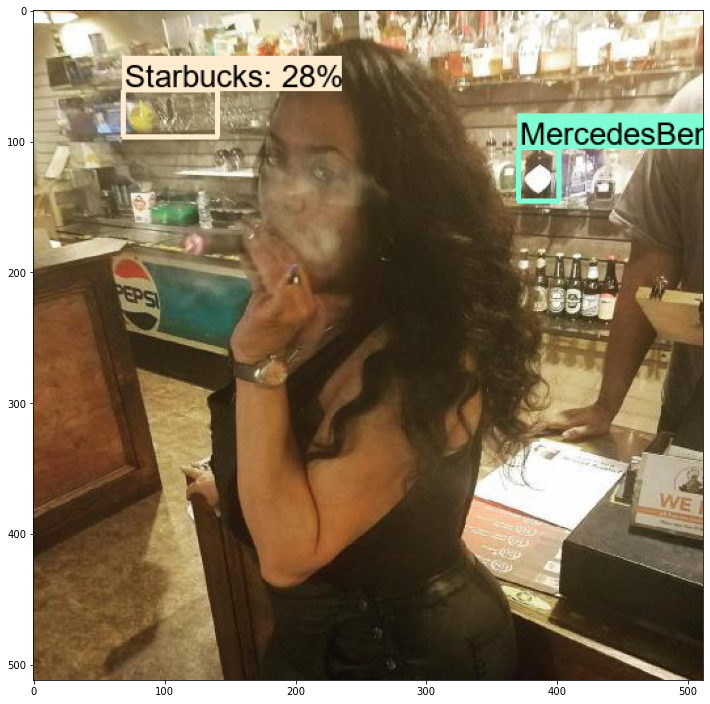

In [37]:
##

item = list(TEST_IMAGE_PATHS)
for img in item:
    print(img)
    print_true_predicted(img)